# Populariteit van een app

Een bedrijf heeft vorige maand een nieuwe app gelanceerd. Ze hebben iedere dag genoteerd hoeveel mensen deze gedownload hebben. Je vindt deze gegevens in “populariteitApp.csv”.

Er zijn in dit geval geen verkeerde of ontbrekende gegevens.  Je zou het bestand dus gemakkelijk moeten kunnen lezen. Je moet wel zorgen dat de kolom "downloads" van het type `float` wordt.


In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing

populariteitApp = pd.read_csv('data/populariteitApp.csv', sep=',')
populariteitApp['downloads'] = populariteitApp['downloads'].astype(float)

display(populariteitApp)

,datum,downloads
0,2013-03-01,2.0
1,2013-03-02,5.0
2,2013-03-03,6.0
3,2013-03-04,4.0
4,2013-03-05,4.0
5,2013-03-06,9.0
6,2013-03-07,9.0
7,2013-03-08,10.0
8,2013-03-09,11.0
9,2013-03-10,13.0


1.	Maak een plot van de gegevens zodat je al wat inzicht krijgt in de data.

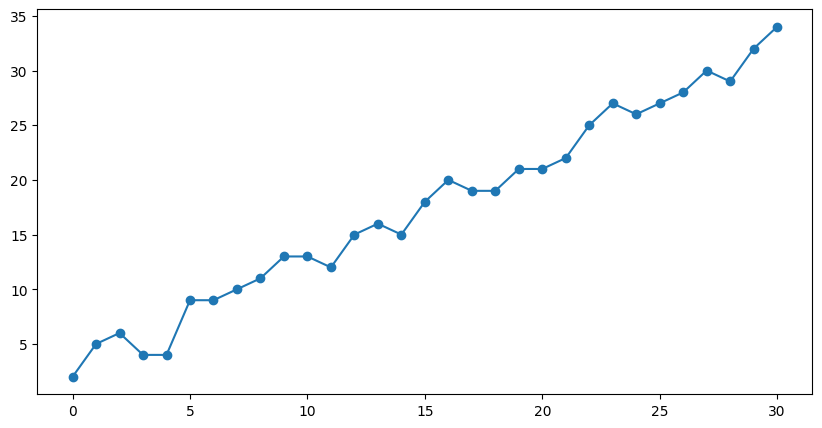

In [20]:
from matplotlib import pyplot as plt

fig,ax=plt.subplots(figsize=(10, 5))
_=ax.plot(populariteitApp.downloads, marker='o')

2.	Kan je de seizoensgrootte vinden?
Tip: gebruik acorr-functie op downloads die je eerst omzet naar Numpy array van floats.

,lags,acf
15,0,1.000000
16,1,0.946835
14,-1,0.946835
13,-2,0.897689
17,2,0.897689
18,3,0.857920
12,-3,0.857920
19,4,0.811788
11,-4,0.811788
20,5,0.766996


Periode: [1]


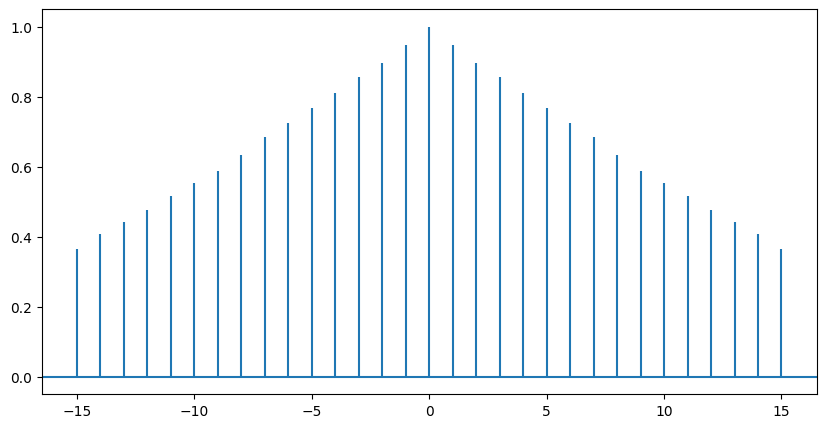

In [21]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def find_period(y: np.array, maxlags=10, top_n=1) -> int:
    acf_vals = acf(y, nlags=maxlags)
    return (np.argsort(-1 * acf_vals)[1:top_n+1])

downloads = populariteitApp['downloads']

fig, ax = plt.subplots(figsize=(10, 5))
lags, acfs, _, _ = ax.acorr(downloads, maxlags=15)
autocorrelatie = pd.DataFrame({'lags': lags, 'acf': acfs}).sort_values(by='acf', ascending=False)
display(autocorrelatie)

periode = find_period(downloads, maxlags=20, top_n=1)
print("Periode:", periode)

3.	Voorspel nu, voor iedere voorspellingsmethode, de drie volgende dagen.  Bereken telkens de MAE, RMSE en de MAPE.

Vervolledig volgende tabel met alle resultaten.

| techniek             | dag 1 | dag 2 | dag 3 | MAE | RMSE | MAPE |
|----------------------|-------|-------|-------|-----|------|------|
| naief (observatie)             | &nbsp;| &nbsp;|&nbsp; |&nbsp;|&nbsp;|&nbsp;|
| average           | &nbsp;| &nbsp;|&nbsp; |&nbsp;|&nbsp;|&nbsp;|
| voortschrijdend(m=5) | &nbsp;| &nbsp;|&nbsp; |&nbsp;|&nbsp;|&nbsp;|
| lin.comb. (m=13)     | &nbsp;| &nbsp;|&nbsp; |&nbsp;|&nbsp;|&nbsp;|
| trend                | &nbsp;| &nbsp;|&nbsp; |&nbsp;|&nbsp;|&nbsp;|
| add. decomp. (m=7)   | &nbsp;| &nbsp;|&nbsp; |&nbsp;|&nbsp;|&nbsp;|
| multi.decomp. (m=7)  | &nbsp;| &nbsp;|&nbsp; |&nbsp;|&nbsp;|&nbsp;|

In [22]:
from W20P4.forecast import *
from statsmodels.tsa.seasonal import seasonal_decompose

n = populariteitApp.downloads.size
nn = n + 3
downloads = populariteitApp.downloads.to_numpy()
# voorspellingen doen voo
naief = predict(downloads, 0, nn, naive)
gemiddelde = predict(downloads, 0, nn, average)
voortschrijdend = predict(downloads, 0, nn, moving_average, 5)
lin_comb = predict(downloads, 0, nn, linear_combination, 13)
trend = create_trend_model(downloads)(np.arange(nn).reshape(-1, 1))
add_model = seasonal_decompose(downloads, model='additive', period=7)
mult_model = seasonal_decompose(downloads, model='multiplicative', period=7)

# voorspellingen voor de komende 3 dagen

# seasonal decompositie voorspellingen hebben twee modellen nodig: regressie en sd model
reg_model = GeneralRegression()
x = np.arange(n)[~np.isnan(add_model.trend)]
y = add_model.trend[~np.isnan(add_model.trend)]
reg_model.fit(x, y)

add_model_pred = seasonal_decomposition_forecast(reg_model, mult_model, 0, nn)
mult_model_pred = seasonal_decomposition_forecast(reg_model, mult_model, 0, nn, method='multiplicative')

dagen = pd.concat([
    pd.Series(naief[n:nn], name='naive'),
    pd.Series(gemiddelde[n:nn], name='gemiddelde'),
    pd.Series(voortschrijdend[n:nn], name='voortschrijdend'),
    pd.Series(lin_comb[n:nn], name='lin_comb'),
    pd.Series(trend[n:nn], name='trend'),
    pd.Series(add_model_pred[n:nn], name='add_model'),
    pd.Series(mult_model_pred[n:nn], name='mult_model')],
    axis=1)
dagen.index = ['dag {}'.format(i) for i in range(1, 4)]

# errors berekenen
errors = pd.concat([
    forecast_errors(downloads, naief[:n], method='naive'),
    forecast_errors(downloads, gemiddelde[:n], method='gemiddelde'),
    forecast_errors(downloads, voortschrijdend[:n], method='voortschrijdend'),
    forecast_errors(downloads, lin_comb[:n], method='lin_comb'),
    forecast_errors(downloads, trend[:n], method='trend'),
    forecast_errors(downloads, add_model_pred[:n], method='add_model'),
    forecast_errors(downloads, mult_model_pred[:n], method='mult_model')])

alleData = pd.merge(dagen.transpose(), errors, left_index=True, right_index=True)
display(alleData)

,dag 1,dag 2,dag 3,MAE,RMSE,MAPE
naive,34.000000,34.000000,34.000000,1.533333,1.914854,0.119949
gemiddelde,17.483871,17.483871,17.483871,8.202828,9.302767,0.433869
voortschrijdend,30.600000,31.120000,31.344000,3.130769,3.366578,0.183542
lin_comb,36.832063,37.384059,42.098808,1.531631,1.780848,0.048856
trend,33.309677,34.298790,35.287903,1.003642,1.156301,0.104034
add_model,33.988637,34.962483,35.936330,1.158930,1.485943,0.132680
mult_model,32.118228,33.065599,34.012969,1.135491,1.323084,0.110438


4.	lineaire combinatie: welke gewichten vind je?  Welke waarde speelt dus de grootste rol in het voorspellen van de volgende waarde?

In [23]:
from W20P4.forecast import bereken_gewichten

gewichten = bereken_gewichten(x, 13)
print(gewichten)

nan


5.	trend: wat is de formule van de regressielijn?

In [24]:
# y = m * x + b
# waarbij:
#     y de afhankelijke variabele is (populairiteit)
#     x de onafhankelijke variabele is (tijd)
#     m de helling van de lijn is (toename van populairiteit per eenheid tijd)
#     b de intercept van de lijn is (populairiteit op tijdstip 0)

6.	additieve decompositie: wat is de formule voor de trendlijn?

In [25]:
# In additieve decompositie wordt de tijdreeks opgesplitst in drie componenten:
# trend, seizoensinvloeden en rest. De formule voor de trendlijn bij additieve
# decompositie kan worden berekend door de trendcomponent te nemen en daarvan de
# seizoensinvloeden en de restcomponent af te trekken:
#
# trendlijn = trend - seizoensinvloeden - rest

7.	additieve decompositie: wat zijn de waarden voor het weerkerend patroon?

In [26]:
additive_model = seasonal_decompose(downloads, model='additive', period=7)
seasonal = pd.DataFrame(additive_model.seasonal)
display(seasonal)

,0
0,-0.741497
1,0.496599
2,1.591837
3,-0.443878
4,-1.408163
5,0.377551
6,0.127551
7,-0.741497
8,0.496599
9,1.591837


8.	multiplicatieve decompositie: wat is de formule voor de trendlijn?

In [27]:
# In een multiplicatieve decompositie wordt de tijdserie geschreven als de product van een trendlijn,
# een seizoenscomponent en een residu. De formule voor de trendlijn in een multiplicatieve decompositie is:
#
# Trend = Y / (S * R)
#
# waarbij Y de oorspronkelijke tijdserie is, S de seizoenscomponent en R het residu.

9.	multiplicatieve decompositie: wat zijn de waarden voor het weerkerend patroon?

In [28]:
multiplicatieve_model = seasonal_decompose(downloads, model='multiplicatieve', period=7)
seasonal = pd.DataFrame(multiplicatieve_model.seasonal[:7])
display(seasonal)

,0
0,0.972813
1,1.034956
2,1.100970
3,0.939276
4,0.863758
5,1.063280
6,1.024946


10.	welke techniek geeft de beste voorspelling en waarom?


In [29]:
multiplicatieve_model = seasonal_decompose(downloads, model='multiplicatieve', period=7)
additive_model = seasonal_decompose(downloads, model='additive', period=7)

n = populariteitApp.downloads.size


predictions = seasonal_decomposition_forecast(reg_model, multiplicatieve_model, 0, 31, method='multiplicative', m=7)
errors = forecast_errors(populariteitApp.downloads, predictions, method='multiplicative_model')
display(errors)

predictions = seasonal_decomposition_forecast(reg_model, additive_model, 0, 31, method='additive', m=7)
errors = forecast_errors(populariteitApp.downloads, predictions, method='additive_model')
display(errors)

,MAE,RMSE,MAPE
multiplicative_model,0.868624,1.153251,0.083637


,MAE,RMSE,MAPE
additive_model,0.507237,0.65991,0.051763


11. Zoek de periode van de dataset.

,lags,acf
15,0,1.000000
16,1,0.946835
14,-1,0.946835
13,-2,0.897689
17,2,0.897689
18,3,0.857920
12,-3,0.857920
19,4,0.811788
11,-4,0.811788
20,5,0.766996


Periode: [1]


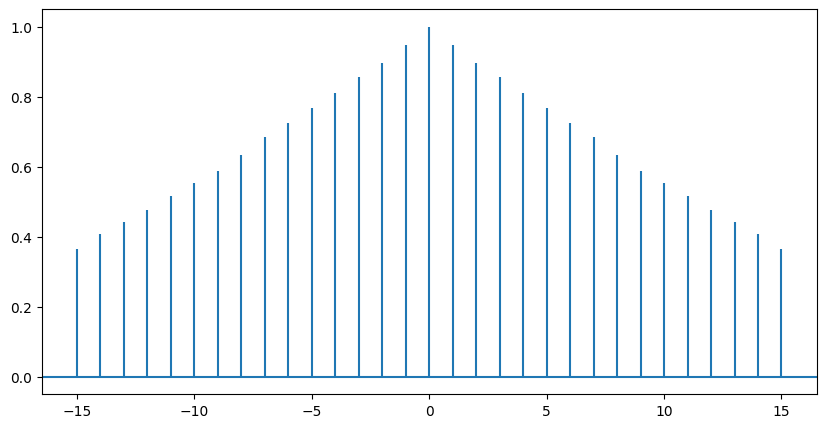

In [30]:
def find_period(y: np.array, maxlags=10, top_n=1) -> int:
    acf_vals = acf(y, nlags=maxlags)
    return (np.argsort(-1 * acf_vals)[1:top_n+1])

downloads = populariteitApp['downloads']

fig, ax = plt.subplots(figsize=(10, 5))
lags, acfs, _, _ = ax.acorr(downloads, maxlags=15)
autocorrelatie = pd.DataFrame({'lags': lags, 'acf': acfs}).sort_values(by='acf', ascending=False)
display(autocorrelatie)

periode = find_period(downloads, maxlags=20, top_n=1)
print("Periode:", periode)